In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-5b15b8961fb8>", line 2, in <module>
    drive.mount('/content/drive')
  File "/usr/local/lib/python3.7/dist-packages/google/colab/drive.py", line 115, in mount
    ephemeral=True)
  File "/usr/local/lib/python3.7/dist-packages/google/colab/drive.py", line 135, in _mount
    'request_auth', request={'authType': 'dfs_ephemeral'}, timeout_sec=None)
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_message.py", line 175, in blocking_request
    return read_reply_from_input(request_id, timeout_sec)
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_message.py", line 101, in read_reply_from_input
    time.sleep(0.025)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/loca

KeyboardInterrupt: ignored

In [ ]:
!git clone https://github.com/shashimalcse/RetailGazeDataset.git

In [ ]:
%cd /content/RetailGazeDataset/retailgaze/

/content/RetailGazeDataset/retailgaze


In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import argparse
import os
from datetime import datetime
import shutil
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import cv2

#from utils_logging import setup_logger

In [ ]:
x=torch.load("/content/drive/MyDrive/RetailGaze/masks/106070644")

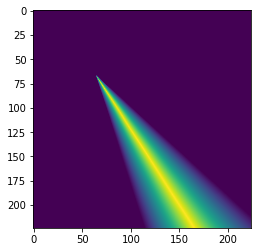

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x.squeeze(0))
plt.show()

In [ ]:
from models.chong import ModelSpatial
from models.__init__ import save_checkpoint, resume_checkpoint
from dataloader.chong import GazeDataset, GooDataset, RetailGaze
from dataloader import chong_imutils
from training.train_chong import train, test, GazeOptimizer

In [ ]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger',
                      log_dir ='./logs/',
                      log_file='train_chong_gooreal.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

In [ ]:
# Dataloaders for GOO-Synth
batch_size=32
workers=12

images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_train.pickle'
test_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
test_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_test.pickle'

train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=16)

test_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = DataLoader(test_set, batch_size=batch_size//2,
                            shuffle=False, num_workers=8)

In [ ]:
!wget https://www.dropbox.com/s/s9y65ajzjz4thve/initial_weights_for_spatial_training.pt
init_weights = 'initial_weights_for_spatial_training.pt'

# Loads model
print("==> Constructing model")
net = ModelSpatial()
net.cuda()

# Hyperparameters
start_epoch = 0
max_epoch = 5
learning_rate = 3e-4

# Initial weights chong
print("==> Loading initial weights")
model_dict = net.state_dict()
pretrained_dict = torch.load(init_weights)
pretrained_dict = pretrained_dict['model']
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict)

# Initializes Optimizer
gaze_opt = GazeOptimizer(net, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)

# Resuming Training
resume_training = False
resume_path = './saved_models/chong_goosynth/model_epoch25.pth.tar'
if resume_training:
    net, optimizer, _ = resume_checkpoint(net, optimizer,resume_path)
    test(net, test_data_loader,logger, save_output=True)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
best_l2 = np.inf

for epoch in range(1,2):

    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    print('training')
    train(net, train_data_loader, optimizer, epoch, logger)

    # Evaluate model
    #scores = test(net, test_data_loader, logger)
    
    # Save model+optimizer with best L2 Scorehttp://localhost:8888/notebooks/train_chong.ipynb#
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/chong_gooreal_notrained/'
    #    save_checkpoint(net, optimizer, 420, save_path)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
best_l2 = np.inf

for epoch in range(1,6):

    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    print('training')
    train(net, train_data_loader, optimizer, epoch, logger)

    # Evaluate model
    #scores = test(net, test_data_loader, logger)
    
    # Save model+optimizer with best L2 Scorehttp://localhost:8888/notebooks/train_chong.ipynb#
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/chong_gooreal_notrained/'
    #    save_checkpoint(net, optimizer, 420, save_path)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
state = {'epoch': 5, 'state_dict': net.state_dict(),
                 'optimizer': optimizer.state_dict(), 'logger': logger, }
torch.save(state, 'Chong_RetailGaze.pt')                 

In [ ]:
torch.save(net.state_dict(), 'Chong_RetailGaze2.pt')

In [ ]:
!pwd

In [ ]:
!cp /content/RetailGazeDataset/retailgaze/Chong_RetailGaze_5.pt /content/drive/MyDrive/checkpoints/Chong_RetailGaze_5.pt

In [ ]:
!cp /content/RetailGazeDataset/retailgaze/Chong_RetailGaze2.pt /content/drive/MyDrive/checkpoints/Chong_RetailGaze2.pt

# Recasens

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel

import time
import os
import numpy as np
import json
import cv2
from PIL import Image, ImageOps
import random
from tqdm import tqdm
import operator
import itertools
from scipy.io import  loadmat
import logging
from scipy import signal

from utils import data_transforms
from utils import get_paste_kernel, kernel_map
from utils_logging import setup_logger

In [ ]:
from models.recasens import GazeNet
from dataloader.recasens import GooDataset, GazeDataset, RetailGaze
from models.__init__ import save_checkpoint, resume_checkpoint
from training.train_recasens import train, test, GazeOptimizer

In [ ]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger', 
                      log_dir ='./logs/',
                      log_file='train_recasens_newauc.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

In [ ]:
# Dataloaders for GazeFollow
batch_size=32
workers=0
testbatchsize=batch_size

images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_train.pickle'
test_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
test_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_test.pickle'

train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

val_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = torch.utils.data.DataLoader(val_set, batch_size=testbatchsize, num_workers=workers, shuffle=False)

In [ ]:
# Loads model

net = GazeNet(placesmodel_path='/content/drive/MyDrive/whole_alexnet_places365.pth')
net.cuda()

# Hyperparameters
start_epoch = 0
max_epoch = 5
learning_rate = 1e-4

# Initializes Optimizer
gaze_opt = GazeOptimizer(net, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)

# Is training resumed? If so, set the resume_path and set flag to True
resume_training = False
resume_path = './saved_models/completed/recasens_goo_epoch4.pth.tar'
if resume_training :
    net, optimizer, _ = resume_checkpoint(net, optimizer, resume_path)
    test(net, test_data_loader,logger, save_output=True)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
best_l2 = np.inf

for epoch in range(1,2):
    
    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    train(net, train_data_loader, optimizer, epoch, logger)
    
    # Evaluate model
    # if epoch+1 in [1,5]:
    #     scores = test(net, test_data_loader, logger, save_output=True)
    
    # Save model+optimizer with best L2 Score
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/recasens_gooreal_notrain/'
    #    save_checkpoint(net, optimizer, 0, save_path)

100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


[0.7703028931658793, 0.24723301350202148, 41.085396918999976]


100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


[0.8183717138291812, 0.2271403062333321, 36.36415428848948]


100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


[0.8082238703720251, 0.23115639951216474, 40.0664788424925]


100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


[0.8038225321230673, 0.2410255134900663, 35.8729475759747]


100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


[0.774930507714052, 0.2619240138277242, 47.49174073947159]


100%|██████████| 19/19 [00:45<00:00,  2.37s/it]


[0.7655631013016412, 0.27260035818045575, 39.54433202156274]


100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


[0.7852815674654077, 0.25327009647916493, 38.287689877027724]


100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


[0.7300980146296515, 0.27527635916826165, 42.915481159436624]


100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


[0.7919419454765398, 0.2466336939701324, 38.273753436674276]


100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


[0.7775063823368048, 0.25541907917999246, 40.62019346553928]


100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


[0.7465895213415542, 0.2750001798212303, 42.521110490097655]


100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


[0.7610692828242358, 0.2610156091741441, 40.61747158775497]


100%|██████████| 19/19 [00:45<00:00,  2.38s/it]


[0.7650482146271533, 0.2592460911221292, 41.19366877946314]


100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


[0.7870820494195123, 0.25278392044764425, 38.11508100163051]


 24%|██▍       | 21/86 [00:51<02:37,  2.43s/it]

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
best_l2 = np.inf

for epoch in range(1,6):
    
    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    train(net, train_data_loader, optimizer, epoch, logger)
    
    # Evaluate model
    # if epoch+1 in [1,5]:
    #     scores = test(net, test_data_loader, logger, save_output=True)
    
    # Save model+optimizer with best L2 Score
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/recasens_gooreal_notrain/'
    #    save_checkpoint(net, optimizer, 0, save_path)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

# Lian

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel

import time
import os
import numpy as np
import json
import cv2
from PIL import Image, ImageOps
import random
from tqdm import tqdm
import operator
import itertools
from scipy.io import  loadmat
import logging
from scipy import signal

from utils import data_transforms
from utils import get_paste_kernel, kernel_map
from utils_logging import setup_logger

In [ ]:
from models.gazenet import GazeNet
from models.__init__ import save_checkpoint, resume_checkpoint
from dataloader.gazenet import GooDataset, GazeDataset, RetailGaze
from training.train_gazenet import train, test, GazeOptimizer

In [ ]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger', 
                      log_dir ='./logs/',
                      log_file='train_gazenet_gooreal_.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

In [ ]:
# Dataloaders for GOO-Synth
batch_size=32
workers=1
testbatchsize=32

images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_train.pickle'
test_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
test_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_test.pickle'


train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

val_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = torch.utils.data.DataLoader(val_set, batch_size=testbatchsize, num_workers=workers, shuffle=False)

In [ ]:
# Loads model
net = GazeNet()
net.cuda()

# Hyperparameters
start_epoch = 0
max_epoch = 30
learning_rate = 1e-4

# Initializes Optimizer
gaze_opt = GazeOptimizer(net, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)

# Is training resumed? If so, set the resume_path and set flag to True
# This can also be used to evaluate a model 
resume_training = False
resume_path = './saved_models/goosynth_pretrain/lian.pth.tar'
if resume_training :
    net, optimizer, _ = resume_checkpoint(net, optimizer, resume_path)
    scores = test(net, test_data_loader,logger, save_output=True)
    #print('L2 Distance: ', scores[1])

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
best_l2 = np.inf

for epoch in range(1, 2):
    
    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    train(net, train_data_loader, optimizer, epoch, logger)
    
    # Evaluate model
    #scores = test(net, test_data_loader, logger)
    
    # Save model+optimizer with best L2 Score
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/gazenet_gooreal_notrain/'
    #    save_checkpoint(net, optimizer, 420, save_path)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

In [ ]:
best_l2 = np.inf

for epoch in range(1, 6):
    
    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    train(net, train_data_loader, optimizer, epoch, logger)
    
    # Evaluate model
    #scores = test(net, test_data_loader, logger)
    
    # Save model+optimizer with best L2 Score
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/gazenet_gooreal_notrain/'
    #    save_checkpoint(net, optimizer, 420, save_path)

In [ ]:
test(net, test_data_loader,logger, save_output=True)

# Face3D

In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import argparse
import os
from datetime import datetime
import shutil
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import cv2

from utils_logging import setup_logger

In [ ]:
!pip install git+https://github.com/zhanghang1989/ResNeSt
!pip install timm

In [ ]:
from models.face3D import Face3D
from models.__init__ import save_checkpoint, resume_checkpoint
from dataloader.face3D import RetailGaze
from dataloader import chong_imutils
from training.face3D import train_face3d, test_face3d, GazeOptimizer

In [ ]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger',
                      log_dir ='./logs/',
                      log_file='train_chong_gooreal.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

In [ ]:
# Dataloaders for GOO-Synth
batch_size=32
workers=12

images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_train.pickle'
test_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
test_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_test.pickle'

train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=16)

test_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = DataLoader(test_set, batch_size=batch_size//2,
                            shuffle=False, num_workers=8)

In [ ]:
net = Face3D()
net.cuda()
start_epoch = 0
max_epoch = 5
learning_rate = 3e-4
gaze_opt = GazeOptimizer(net, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)



In [ ]:
test_face3d(net, test_data_loader,logger, save_output=True)

# Hypo

In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import argparse
import os
from datetime import datetime
import shutil
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import cv2

from utils_logging import setup_logger

In [ ]:
!pip install pytorchcvtcolor

In [ ]:
from models.hypo import Shashimal2_VGG
from models.__init__ import save_checkpoint, resume_checkpoint
from dataloader.hypo import RetailGaze
from dataloader import chong_imutils
from training.train_hypo import train, test, GazeOptimizer

In [ ]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger',
                      log_dir ='./logs/',
                      log_file='train_chong_gooreal.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

In [ ]:
# Dataloaders for GOO-Synth
batch_size=32
workers=12

images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_train2.pickle'
test_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
test_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_test2.pickle'
val_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
val_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_valid2.pickle'

train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=16)

test_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = DataLoader(test_set, batch_size=1,
                            shuffle=False, num_workers=4)

val_set = RetailGaze(val_images_dir, val_pickle_path, 'train')
val_data_loader = DataLoader(val_set, batch_size=batch_size//2,
                            shuffle=False, num_workers=8)

Number of Images: 2728
Number of Images: 609
Number of Images: 585


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = Shashimal2_VGG()


model_ft = model_ft.to(device)

criterion = nn.NLLLoss().cuda()
# criterion =

# Observe that all parameters are being optimized
start_epoch = 0
max_epoch = 5
learning_rate = 1e-4

# Initializes Optimizer
gaze_opt = GazeOptimizer(model_ft, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)

23


In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/shashimal2')

%reload_ext tensorboard
%tensorboard --logdir="runs/" 

In [ ]:
model_ft = train(model_ft, train_data_loader, val_data_loader, criterion, optimizer, logger, writer,num_epochs=20, patience=10)

NameError: ignored

In [ ]:
if True:
    checkpoint_fpath = '/content/drive/MyDrive/shashimal2_goo_new_9.pt'
    checkpoint = torch.load(checkpoint_fpath)
    model_ft.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


In [ ]:
test(model_ft, test_data_loader, logger)

proximate accuracy: [0.01313629 0.05747126 0.13464696 0.408867   0.66502463 0.77175698
 0.87192118 0.93267652]
average error: [0.9444069211777723, 0.14184186289551515, 11.233993243353616]


[0.9444069211777723, 0.14184186289551515, 11.233993243353616]

In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import argparse
import os
from datetime import datetime
import shutil
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import cv2

from utils_logging import setup_logger

In [ ]:
!pip install pytorchcvtcolor

In [ ]:
from models.hypochong import HypoChong
from models.__init__ import save_checkpoint, resume_checkpoint
from dataloader.hypochong import GazeDataset, GooDataset, RetailGaze
from dataloader import chong_imutils
from training.train_hypochong import train, test, GazeOptimizer

In [ ]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger',
                      log_dir ='./logs/',
                      log_file='train_chong_gooreal.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

In [ ]:
# Dataloaders for GOO-Synth
batch_size=32
workers=12

images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_train2.pickle'
test_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
test_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_test2.pickle'
val_images_dir = '/content/drive/MyDrive/RetailGaze/RetailGaze_V2/'
val_pickle_path = '/content/drive/MyDrive/RetailGaze/RetailGaze_V3_valid2.pickle'

train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=16)

test_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = DataLoader(test_set, batch_size=1,
                            shuffle=False, num_workers=4)

val_set = RetailGaze(val_images_dir, val_pickle_path, 'train')
val_data_loader = DataLoader(val_set, batch_size=batch_size//2,
                            shuffle=False, num_workers=8)

Number of Images: 2728


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number of Images: 609
Number of Images: 585


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:


# Loads model
print("==> Constructing model")
net = HypoChong()

net.cuda()
# Hyperparameters
start_epoch = 0
max_epoch = 5
learning_rate = 3e-4

# Initial weights chong


# Initializes Optimizer
gaze_opt = GazeOptimizer(net, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)

# # Resuming Training
# if True:
#     checkpoint_fpath = '/content/drive/MyDrive/shashimal2_hypochong_new_0.pt'
#     checkpoint = torch.load(checkpoint_fpath)
#     net.load_state_dict(checkpoint['state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer'])


==> Constructing model


In [ ]:
test(net, test_data_loader,logger, save_output=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 609/609 [00:23<00:00, 26.29it/s]
average error: [0.5793633380158776, 0.3539387367954965, 38.24889572257457]


[0.5793633380158776, 0.3539387367954965, 38.24889572257457]

In [ ]:
test(net, test_data_loader,logger, save_output=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 609/609 [00:22<00:00, 26.76it/s]
average error: [0.5399521679460528, 0.7852711459667392, 98.0750974296619]


[0.5399521679460528, 0.7852711459667392, 98.0750974296619]

In [ ]:
train(net, train_data_loader, val_data_loader, optimizer, logger,num_epochs=100, patience=10)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 86/86 [01:03<00:00,  1.35it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that exces

[  0/100] valid_loss: 531.70178
Validation loss decreased (inf --> 531.701782).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.18it/s]


[  1/100] valid_loss: 506.18985
Validation loss decreased (531.701782 --> 506.189855).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.31it/s]


[  2/100] valid_loss: 481.78462
Validation loss decreased (506.189855 --> 481.784624).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.35it/s]


[  3/100] valid_loss: 453.80222
Validation loss decreased (481.784624 --> 453.802219).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.33it/s]


[  4/100] valid_loss: 430.65802
Validation loss decreased (453.802219 --> 430.658024).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.27it/s]


[  5/100] valid_loss: 389.35670
Validation loss decreased (430.658024 --> 389.356698).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.39it/s]


[  6/100] valid_loss: 367.85109
Validation loss decreased (389.356698 --> 367.851093).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.32it/s]


[  7/100] valid_loss: 344.84770
Validation loss decreased (367.851093 --> 344.847705).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.33it/s]


[  8/100] valid_loss: 321.89815
Validation loss decreased (344.847705 --> 321.898151).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.33it/s]


[  9/100] valid_loss: 304.05259
Validation loss decreased (321.898151 --> 304.052585).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.29it/s]


[ 10/100] valid_loss: 243.97827
Validation loss decreased (304.052585 --> 243.978274).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.31it/s]


[ 11/100] valid_loss: 235.24575
Validation loss decreased (243.978274 --> 235.245746).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.41it/s]


[ 12/100] valid_loss: 219.53854
Validation loss decreased (235.245746 --> 219.538540).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.38it/s]


[ 13/100] valid_loss: 195.84413
Validation loss decreased (219.538540 --> 195.844134).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.35it/s]


[ 14/100] valid_loss: 187.73816
Validation loss decreased (195.844134 --> 187.738165).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.29it/s]


[ 15/100] valid_loss: 182.42181
Validation loss decreased (187.738165 --> 182.421810).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.28it/s]


[ 16/100] valid_loss: 175.65214
Validation loss decreased (182.421810 --> 175.652141).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]


[ 17/100] valid_loss: 161.32730
Validation loss decreased (175.652141 --> 161.327303).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.23it/s]


[ 18/100] valid_loss: 156.52158
Validation loss decreased (161.327303 --> 156.521583).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.09it/s]


[ 19/100] valid_loss: 152.58298
Validation loss decreased (156.521583 --> 152.582976).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]


[ 20/100] valid_loss: 129.57263
Validation loss decreased (152.582976 --> 129.572629).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.24it/s]


[ 21/100] valid_loss: 126.35928
Validation loss decreased (129.572629 --> 126.359281).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.24it/s]


[ 22/100] valid_loss: 123.27869
Validation loss decreased (126.359281 --> 123.278686).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.19it/s]


[ 23/100] valid_loss: 120.88988
Validation loss decreased (123.278686 --> 120.889884).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.28it/s]


[ 24/100] valid_loss: 119.52698
Validation loss decreased (120.889884 --> 119.526977).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]


[ 25/100] valid_loss: 115.83058
Validation loss decreased (119.526977 --> 115.830580).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.22it/s]


[ 26/100] valid_loss: 113.01206
Validation loss decreased (115.830580 --> 113.012055).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]


[ 27/100] valid_loss: 110.67207
Validation loss decreased (113.012055 --> 110.672068).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.19it/s]


[ 28/100] valid_loss: 108.33745
Validation loss decreased (110.672068 --> 108.337451).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.25it/s]


[ 29/100] valid_loss: 105.86710
Validation loss decreased (108.337451 --> 105.867101).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.28it/s]


[ 30/100] valid_loss: 103.03964
Validation loss decreased (105.867101 --> 103.039643).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.27it/s]


[ 31/100] valid_loss: 101.47114
Validation loss decreased (103.039643 --> 101.471137).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]


[ 32/100] valid_loss: 100.29260
Validation loss decreased (101.471137 --> 100.292600).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.25it/s]


[ 33/100] valid_loss: 97.72068
Validation loss decreased (100.292600 --> 97.720677).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.25it/s]


[ 34/100] valid_loss: 96.20881
Validation loss decreased (97.720677 --> 96.208809).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.22it/s]


[ 35/100] valid_loss: 93.82397
Validation loss decreased (96.208809 --> 93.823973).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.25it/s]


[ 36/100] valid_loss: 92.62658
Validation loss decreased (93.823973 --> 92.626584).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.16it/s]


[ 37/100] valid_loss: 90.78561
Validation loss decreased (92.626584 --> 90.785612).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.14it/s]


[ 38/100] valid_loss: 88.95982
Validation loss decreased (90.785612 --> 88.959823).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.23it/s]


[ 39/100] valid_loss: 86.14323
Validation loss decreased (88.959823 --> 86.143225).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.24it/s]


[ 40/100] valid_loss: 84.62372
Validation loss decreased (86.143225 --> 84.623721).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.19it/s]


[ 41/100] valid_loss: 80.08204
Validation loss decreased (84.623721 --> 80.082036).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.20it/s]


[ 42/100] valid_loss: 72.71089
Validation loss decreased (80.082036 --> 72.710886).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.29it/s]

[ 43/100] valid_loss: 73.45171
EarlyStopping counter: 1 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]

[ 44/100] valid_loss: 74.17027
EarlyStopping counter: 2 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.16it/s]

[ 45/100] valid_loss: 73.72775
EarlyStopping counter: 3 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.28it/s]

[ 46/100] valid_loss: 72.85882
EarlyStopping counter: 4 out of 10



 43%|████▎     | 37/86 [00:06<00:09,  5.30it/s]


[ 47/100] valid_loss: 72.03647
Validation loss decreased (72.710886 --> 72.036473).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.24it/s]


[ 48/100] valid_loss: 71.81592
Validation loss decreased (72.036473 --> 71.815920).  Saving model ...


 43%|████▎     | 37/86 [00:06<00:09,  5.34it/s]

[ 49/100] valid_loss: 71.83363
EarlyStopping counter: 1 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.28it/s]

[ 50/100] valid_loss: 72.44836
EarlyStopping counter: 2 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.26it/s]


[ 51/100] valid_loss: 71.66732
Validation loss decreased (71.815920 --> 71.667320).  Saving model ...


 43%|████▎     | 37/86 [00:07<00:09,  5.18it/s]

[ 52/100] valid_loss: 71.80135
EarlyStopping counter: 1 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.19it/s]

[ 53/100] valid_loss: 72.25480
EarlyStopping counter: 2 out of 10



 43%|████▎     | 37/86 [00:06<00:09,  5.30it/s]

[ 54/100] valid_loss: 72.53860
EarlyStopping counter: 3 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.22it/s]

[ 55/100] valid_loss: 73.08460
EarlyStopping counter: 4 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.21it/s]

[ 56/100] valid_loss: 73.07024
EarlyStopping counter: 5 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.23it/s]

[ 57/100] valid_loss: 73.76512
EarlyStopping counter: 6 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.21it/s]

[ 58/100] valid_loss: 73.68870
EarlyStopping counter: 7 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.27it/s]

[ 59/100] valid_loss: 73.44243
EarlyStopping counter: 8 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.27it/s]

[ 60/100] valid_loss: 73.62539
EarlyStopping counter: 9 out of 10



 43%|████▎     | 37/86 [00:07<00:09,  5.23it/s]

[ 61/100] valid_loss: 74.18102
EarlyStopping counter: 10 out of 10
Early stopping
